# First paper - Figure 1 & 2 & 3
### Climatology of wind and solar power with synoptic weather patterns
<br>(2021-10-04) use **time series**
- Fig 3: bar plots if generation anomalies for PV, wind and total power
- Fig 4: scatter plots of anomalies

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt
import seaborn as sns

import matplotlib.pyplot as plt
from pylab import savefig
plt.switch_backend('agg')  # save image in plt

from pandas.api.types import CategoricalDtype

from utils_LH import Dir, new_lat, new_lon, df_GWL, list_lgcGWL, anomalies_perGWL, GWL_groups, GWL_table, df_GWL_season
from utils_LH import colour_list_GWL_groups, color_PV_wind_total

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]  # increase size of inline figure

/net/respos/linhho/energy_model/
/home/linhho/Documents/Code_PhD/CONST//COSMO_REA6_CONST_withOUTsponge.nc
   Year  Month  Day  id_EGWL EGWL  id_lgcGWL lgcGWL       Date  Season
0  1995      1    1       20   Np         13     Nz 1995-01-01  winter
1  1995      1    2       20   Np         13     Nz 1995-01-02  winter
2  1995      1    3       20   Np         13     Nz 1995-01-03  winter
3  1995      1    4        7  BMp         10     BM 1995-01-04  winter
4  1995      1    5        7  BMp         10     BM 1995-01-05  winter
      Year  Month  Day  id_EGWL EGWL  id_lgcGWL lgcGWL       Date  Season
9232  2020      4   11        1  HMa          9     HM 2020-04-11  winter
9233  2020      4   12        1  HMa          9     HM 2020-04-12  winter
9234  2020      4   13       18  HBc         16     HB 2020-04-13  winter
9235  2020      4   14       18  HBc         16     HB 2020-04-14  winter
9236  2020      4   15       18  HBc         16     HB 2020-04-15  winter


/home/linhho/miniconda3/envs/py3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [2]:
# select only period of interest <========== and SEASON !!!
period = [1995,2017]
name_PERIOD = '{}_{}'.format(period[0], period[1])
print(name_PERIOD)

df_daily_all = df_GWL_season.loc[(df_GWL_season['Year']>=period[0]) & (df_GWL_season['Year']<=period[1])].copy()  # deep copy to create a real new copy not depend on the old df
df_hourly_all =  df_daily_all.set_index('Date').to_period().resample('H').ffill()

df_daily_all

1995_2017


,Year,Month,Day,id_EGWL,EGWL,id_lgcGWL,lgcGWL,Date,Season
0,1995,1,1,20,Np,13,Nz,1995-01-01,winter
1,1995,1,2,20,Np,13,Nz,1995-01-02,winter
2,1995,1,3,20,Np,13,Nz,1995-01-03,winter
3,1995,1,4,7,BMp,10,BM,1995-01-04,winter
4,1995,1,5,7,BMp,10,BM,1995-01-05,winter
...,...,...,...,...,...,...,...,...,...
8396,2017,12,27,49,TrWr,29,TrW,2017-12-27,winter
8397,2017,12,28,49,TrWr,29,TrW,2017-12-28,winter
8398,2017,12,29,10,Wz,2,Wz,2017-12-29,winter
8399,2017,12,30,10,Wz,2,Wz,2017-12-30,winter


In [31]:
### Time series with wind onshore and offshore threshold 0.5 for reviewed paper
### 2023-09-12
stop
# label = 'on_offshore_wind_scen2050'
label = 'on_offshore_wind_scale2019'

d=xr.open_dataset("/home/linhho/Documents/Code_PhD/CONST/COSMO_REA6_CONST_withOUTsponge.nc")
mask_land = d['FR_LAND'].data[::8, ::8] <= .5  ## masked OUT???
mask_sea  = d['FR_LAND'].data[::8, ::8] > .5

ts_all = pd.DataFrame(columns = ['time','PV', 'Wp_on', 'Wp_off'])

for year in range(1995,2018):
    print(year, end =', ')
#     fname = Dir['out_dir'] + str(year) + '_PV_wind_generation_v2.nc'
    fname = Dir['out_dir'] + '/scale2019/' + str(year) + '_PV_wind_generation_scale2019.nc'
    ds = xr.open_dataset(fname)
    tmp_wp_on = np.ma.array(ds['Wp2050'].data, mask=np.tile(mask_land, (len(ds.time),1,1)))
    tmp_wp_off = np.ma.array(ds['Wp2050'].data, mask=np.tile(mask_sea, (len(ds.time),1,1)))

    tmp_ts = pd.DataFrame({'time': pd.date_range(dt.datetime(year,1,1,0,0,0), dt.datetime(year+1,1,1,0,0,0), freq='H', closed="left"),
                               'PV': np.nansum(ds['PV2050'].data, axis=(1,2))/1000,
                               'Wp_on': np.nansum(tmp_wp_on, axis=(1,2))/1000,
                               'Wp_off': np.nansum(tmp_wp_off, axis=(1,2))/1000,
                               },
                             columns = ['time','PV', 'Wp_on', 'Wp_off'])
    ts_all = pd.concat([ts_all, tmp_ts])

print(fname, '\n Make sure there is no NaN in the time series ', np.sum(np.isnan(ts_all['PV'])), np.sum(np.isnan(ts_all['Wp_on'])), np.sum(np.isnan(ts_all['Wp_off'])))
print('Mean hourly production {} onshore {:.2f} and offshore {:.2f} GW'.format(label, ts_all['Wp_on'].mean(), ts_all['Wp_off'].mean()))

today = dt.datetime.today().strftime('%Y%m%d')
fname = '/net/respos/linhho/energy_model/mask/Timeseries_Europe_hourly_{}_{}_GW_{}.csv'.format(name_PERIOD, label, today)
ts_all.to_csv(fname, sep='\t', index=False)

1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, /net/respos/linhho/energy_model//scale2019/2017_PV_wind_generation_scale2019.nc 
 Make sure there is no NaN in the time series  0 0 0
Mean hourly production on_offshore_wind_scale2019 onshore 25.67 and offshore 31.76 GW


In [32]:
print('Mean hourly production {} onshore {:.2f} and offshore {:.2f} GW'.format(label, ts_all['Wp_on'].mean(), ts_all['Wp_off'].mean()))

Mean hourly production on_offshore_wind_scale2019 onshore 25.67 and offshore 31.76 GW


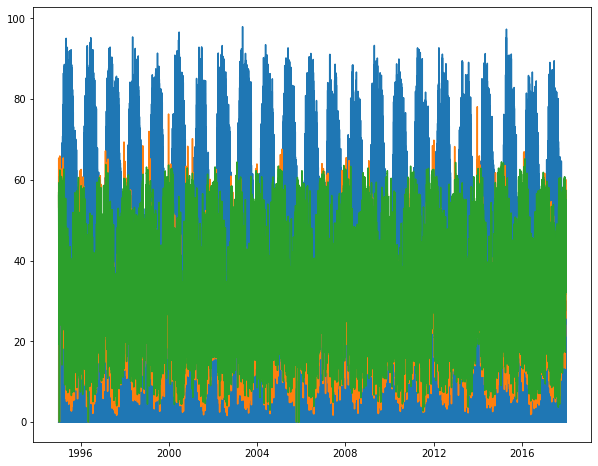

In [33]:
plt.plot(ts_all.set_index('time'))
# ts_all

In [91]:
# # read energy data
# fname = Dir['out_dir'] + '????_PV_wind_generation_v2.nc'
# # fname = '/net/respos/linhho/energy_model/newratio5/????_PV_wind_generation_newratio5.nc'
# ds = xr.open_mfdataset(fname, parallel=True)
# ds

# # a[np.isnan(a)] = 0
# # time series (sum of all Europe), then convert to GW/hour
# PV = ds['PV2050'].sum(axis=(1,2)).load()/1000
# Wp = ds['Wp2050'].sum(axis=(1,2)).load()/1000

<xarray.Dataset>
Dimensions:    (lat: 106, lon: 103, time: 201624)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 ... 2017-12-31T23:00:00
Dimensions without coordinates: lat, lon
Data variables:
    PV2050_CF  (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
    Wp2050     (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
    Wp_CF      (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
    Wp2050_CF  (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
    Wp         (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
    PV2050     (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
Attributes:
    Conventions:  
    Title:        Energy model output version 2 (2021-09-07)
    Author:       Linh Ho, Institute of Geophysics and Meteorology, Universit...
    History:      2023-01-03 16:34:17.975231 Python2
    References:   
    Notes:        Wind speed at hubheight interpolated from wind at level 36 ...

## Preprocess time series for energy output
- *No* separate wind offshore
- Save in GW/hour
- Convert NaN to zero before calculate sum of whole Europe (axis 1,2) to make sure...

In [93]:
# ts_all = pd.DataFrame({'time': pd.date_range(dt.datetime(period[0],1,1,0,0,0), dt.datetime(period[1]+1,1,1,0,0,0), freq='H', closed="left"),
#                            'PV': PV,
#                            'Wp': Wp,
#                            },
#                          columns = ['time','PV', 'Wp'])

# print(fname, '\n Make sure there is no NaN in the time series ', np.sum(np.isnan(ts_all['PV'])), np.sum(np.isnan(ts_all['Wp'])))
# ts_all

# label = 'newratio5'
# today = dt.datetime.today().strftime('%Y%m%d')
# fname = 'Timeseries_all_hourly_{}_{}_GW_{}.csv'.format(name_PERIOD, label, today)
# # ts_all.to_csv(fname, sep='\t', index=False)

/net/respos/linhho/energy_model/newratio5/????_PV_wind_generation_newratio5.nc 
 Make sure there is no NaN in the time series  0 0


,time,PV,Wp
0,1995-01-01 00:00:00,0.000000,109.414822
1,1995-01-01 01:00:00,0.000000,111.102982
2,1995-01-01 02:00:00,0.000000,114.063530
3,1995-01-01 03:00:00,0.000000,113.950713
4,1995-01-01 04:00:00,-0.000557,113.635812
...,...,...,...
201619,2017-12-31 19:00:00,0.000000,106.095340
201620,2017-12-31 20:00:00,0.000000,105.996750
201621,2017-12-31 21:00:00,0.000000,107.805036
201622,2017-12-31 22:00:00,0.000000,107.513588


,time,PV,Wp_on,Wp_off
0,1995-01-01 00:00:00,0.000000,147.860306,140.418259
1,1995-01-01 01:00:00,0.000000,146.807327,145.919083
2,1995-01-01 02:00:00,0.000000,150.096161,150.430527
3,1995-01-01 03:00:00,0.000000,149.574036,150.655396
4,1995-01-01 04:00:00,-0.000557,149.030151,150.369614
...,...,...,...,...
201619,2017-12-31 19:00:00,0.000000,141.993530,137.539108
201620,2017-12-31 20:00:00,0.000000,140.303421,138.969452
201621,2017-12-31 21:00:00,0.000000,141.855255,142.181976
201622,2017-12-31 22:00:00,0.000000,140.855286,142.414047


## Fig 3: Barplot
Anomalies of PV, wind and total generation for sum Europe (GW/hour)

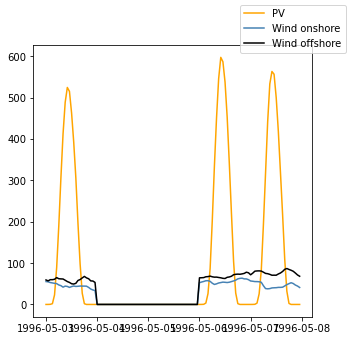

In [34]:
# name_scen = 'scale2019'
name_scen = 'scen2050'

fname = '/net/respos/linhho/energy_model/mask/Timeseries_Europe_hourly_{}_on_offshore_wind_{}_GW.csv'.format(name_PERIOD, name_scen) ## with on offshore
# fname = 'Timeseries_all_hourly_{}_GW_{}.csv'.format(name_PERIOD, name_scen)  # withOUT on offshore

ts_all_from_file = pd.read_csv(fname, sep='\t')
ts_all_raw = ts_all_from_file.copy()
ts_all_raw['time'] = pd.to_datetime(ts_all_raw['time'])
ts_all_from_file

# DAILY ========== !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
ts_all_raw['Wp'] = ts_all_raw['Wp_on'] + ts_all_raw['Wp_off']
ts_all_raw['total'] = ts_all_raw['PV'] + ts_all_raw['Wp_on'] + ts_all_raw['Wp_off']
ts_all_raw['Season'] = df_hourly_all['Season'].tolist()
ts_all_raw['GWL'] = df_hourly_all['lgcGWL'].tolist()
ts_all_raw = ts_all_raw.set_index('time')

# from 2022-06-02, remove these 5 dates with missing data, denote as _v5
# replace 1996-05-04--05 all zeros with None GWL to ignore in calculation
ts_all_raw.loc['1996-05-04 00:00:00':'1996-05-05 23:00:00', 'GWL'] = None
ts_all_raw.loc['2017-12-06 00:00:00':'2017-12-06 23:00:00', 'GWL'] = None
ts_all_raw.loc['2005-10-17 00:00:00':'2005-10-17 23:00:00', 'GWL'] = None

# Small Wp=0.18
ts_all_raw.loc['1995-01-12 00:00:00':'1995-01-12 23:00:00', 'GWL'] = None

check = ts_all_raw.loc['1996-05-03':'1996-05-07']
fig,axes = plt.subplots(figsize=(5,5))
axes.plot(check['PV'], label='PV', color='orange')
axes.plot(check['Wp_on'], label='Wind onshore', color='steelblue')
axes.plot(check['Wp_off'], label='Wind offshore', color='black')
fig.legend()

In [35]:
## Dataframe of all statictics necessary to create the barplot/scatter of anomalies by GWL

## Select SEASON
season_sel = 'annual'

if season_sel == 'annual': ts_all = ts_all_raw.copy() ;
else: ts_all = ts_all_raw[ts_all_raw['Season']==season_sel].copy()

#### hourly mean of energy type in season_sel (winter/summer/annual)
mean_total = np.nanmean(ts_all['total'])
mean_PV = np.nanmean(ts_all['PV'])
mean_Wp_on = np.nanmean(ts_all['Wp_on'])
mean_Wp_off = np.nanmean(ts_all['Wp_off'])
mean_Wp = np.nanmean(ts_all['Wp'])
print(name_scen, season_sel)
print('Mean total {:.2f}, mean PV {:.2f}, wind onshore {:.2f}, wind offshore {:.2f} GW'.format(
    mean_total, mean_PV, mean_Wp_on, mean_Wp_off))
print('Percentage of PV power produces in the energy mix is {:.2f}'.format(mean_PV/mean_total))

## Anomalies (percentage) compared to mean hourly production of GWL of season
stat_anomalies = ts_all.groupby(['GWL']).mean()
stat_anomalies['total'] = (stat_anomalies['total'] - mean_total)/mean_total*100
stat_anomalies['PV'] = (stat_anomalies['PV'] - mean_PV)/mean_PV*100

stat_anomalies['fraction_on']  = stat_anomalies['Wp_on'] / stat_anomalies['Wp']
stat_anomalies['fraction_off']  = stat_anomalies['Wp_off'] / stat_anomalies['Wp']
stat_anomalies['Wp'] = (stat_anomalies['Wp'] - mean_Wp)/mean_Wp*100
stat_anomalies['Wp_on'] = stat_anomalies['Wp'] * stat_anomalies['fraction_on']
stat_anomalies['Wp_off'] = stat_anomalies['Wp'] * stat_anomalies['fraction_off']

stat_anomalies['Season'] = season_sel

# Count the number of days with GWL
counts = ts_all.groupby(['GWL'])
ts_all_count = counts.size()/24 # actually a pd Series, both are 24 hours a day so don't need to divide by 24

stat_anomalies['count_total'] = len(ts_all)/24
stat_anomalies['count_day'] = np.nan
for GWL in list_lgcGWL:
    stat_anomalies.at[GWL, 'count_day'] = ts_all_count[GWL]
    
to_barplot2050 = stat_anomalies[stat_anomalies['Season']==season_sel].copy() #.set_index('GWL')

for GWL in list_lgcGWL:
    to_barplot2050.at[GWL, 'frequency'] = to_barplot2050.at[GWL, 'count_day'] / to_barplot2050.at[GWL, 'count_total'] * 100

to_barplot2050['Group'] = None
for group in list(GWL_groups.keys()):
    print(group)
    for GWL in GWL_groups[group]:
        to_barplot2050.at[GWL, 'Group'] = group
    
to_barplot2050.reset_index(drop=False, inplace=True)
to_barplot2050

scen2050 annual
Mean total 280.94, mean PV 129.65, wind onshore 67.63, wind offshore 83.67 GW
Percentage of PV power produces in the energy mix is 0.46
group1_highwindlowPV
group2_average
group3_lowwindhighPV
group4_darkdoldrum


,GWL,PV,Wp_on,Wp_off,Wp,total,fraction_on,fraction_off,Season,count_total,count_day,frequency,Group
0,BM,11.660215,-4.658031,-5.902175,-10.560206,-0.305852,0.441093,0.558907,annual,8401.0,778.0,9.260802,group3_lowwindhighPV
1,HB,9.366263,-9.930441,-12.794467,-22.724909,-7.915368,0.436985,0.563015,annual,8401.0,266.0,3.166290,group3_lowwindhighPV
2,HFa,5.693870,-5.153060,-6.720174,-11.873234,-3.766309,0.434006,0.565994,annual,8401.0,214.0,2.547316,group2_average
3,HFz,-3.389638,-3.668561,-4.568341,-8.236902,-5.999971,0.445381,0.554619,annual,8401.0,255.0,3.035353,group2_average
4,HM,6.021056,-8.493435,-10.627370,-19.120805,-7.518255,0.444199,0.555801,annual,8401.0,351.0,4.178074,group3_lowwindhighPV
5,HNFa,27.724137,-9.567366,-13.965305,-23.532671,0.121491,0.406557,0.593443,annual,8401.0,175.0,2.083085,group3_lowwindhighPV
6,HNFz,-9.518246,-5.852927,-8.276846,-14.129774,-12.001630,0.414227,0.585773,annual,8401.0,218.0,2.594929,group2_average
7,HNa,11.792062,-12.496271,-16.663740,-29.160011,-10.261313,0.428541,0.571459,annual,8401.0,260.0,3.094870,group4_darkdoldrum
8,HNz,13.420539,-10.801331,-12.961425,-23.762756,-6.603286,0.454549,0.545451,annual,8401.0,196.0,2.333056,group3_lowwindhighPV
9,NEa,6.160970,-11.282786,-12.855226,-24.138012,-10.155537,0.467428,0.532572,annual,8401.0,152.0,1.809308,group3_lowwindhighPV


In [36]:
to_barplot2050.groupby('Group')['frequency'].sum()

Group
group1_highwindlowPV    32.793715
group2_average          28.353767
group3_lowwindhighPV    31.674801
group4_darkdoldrum       7.118200
Name: frequency, dtype: float64

In [37]:
import gc
gc.collect()

40118

In [38]:
##### 2019 to_barplot2019
## Dataframe of all statictics necessary to create the barplot/scatter of anomalies by GWL

name_scen = 'scale2019'
fname = '/net/respos/linhho/energy_model/mask/Timeseries_Europe_hourly_{}_on_offshore_wind_{}_GW.csv'.format(name_PERIOD, name_scen) ## with on offshore
ts_all_from_file = pd.read_csv(fname, sep='\t')
ts_all_raw = ts_all_from_file.copy()
ts_all_raw['time'] = pd.to_datetime(ts_all_raw['time'])
ts_all_from_file

# DAILY ========== !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
ts_all_raw['Wp'] = ts_all_raw['Wp_on'] + ts_all_raw['Wp_off']
ts_all_raw['total'] = ts_all_raw['PV'] + ts_all_raw['Wp_on'] + ts_all_raw['Wp_off']
ts_all_raw['Season'] = df_hourly_all['Season'].tolist()
ts_all_raw['GWL'] = df_hourly_all['lgcGWL'].tolist()
ts_all_raw = ts_all_raw.set_index('time')
# from 2022-06-02, remove these 5 dates with missing data, denote as _v5
# replace 1996-05-04--05 all zeros with None GWL to ignore in calculation
ts_all_raw.loc['1996-05-04 00:00:00':'1996-05-05 23:00:00', 'GWL'] = None
ts_all_raw.loc['2017-12-06 00:00:00':'2017-12-06 23:00:00', 'GWL'] = None
ts_all_raw.loc['2005-10-17 00:00:00':'2005-10-17 23:00:00', 'GWL'] = None
# Small Wp=0.18
ts_all_raw.loc['1995-01-12 00:00:00':'1995-01-12 23:00:00', 'GWL'] = None

## Select SEASON
if season_sel == 'annual': ts_all = ts_all_raw.copy() ;
else: ts_all = ts_all_raw[ts_all_raw['Season']==season_sel].copy()

#### hourly mean of energy type in season_sel (winter/summer/annual)
mean_total = np.nanmean(ts_all['total'])
mean_PV = np.nanmean(ts_all['PV'])
mean_Wp_on = np.nanmean(ts_all['Wp_on'])
mean_Wp_off = np.nanmean(ts_all['Wp_off'])
mean_Wp = np.nanmean(ts_all['Wp'])
print(name_scen, season_sel)
print('Mean total {:.2f}, mean PV {:.2f}, wind onshore {:.2f}, wind offshore {:.2f} GW'.format(
    mean_total, mean_PV, mean_Wp_on, mean_Wp_off))
print('Percentage of PV power produces in the energy mix is {:.2f}'.format(mean_PV/mean_total))

## Anomalies (percentage) compared to mean hourly production of GWL of season
stat_anomalies = ts_all.groupby(['GWL']).mean()
stat_anomalies['total'] = (stat_anomalies['total'] - mean_total)/mean_total*100
stat_anomalies['PV'] = (stat_anomalies['PV'] - mean_PV)/mean_PV*100

### fraction_on and off means how much (absolute value) anomalies of wind power come from wind on and offshore
### calculate using normalised anomalies separately for wind on and offshore would give too large value, easily > 80% in most cases for wind offshore
### and thus completely change Fig 1
stat_anomalies['fraction_on']  = stat_anomalies['Wp_on'] / stat_anomalies['Wp']
stat_anomalies['fraction_off']  = stat_anomalies['Wp_off'] / stat_anomalies['Wp']
stat_anomalies['Wp'] = (stat_anomalies['Wp'] - mean_Wp)/mean_Wp*100
stat_anomalies['Wp_on'] = stat_anomalies['Wp'] * stat_anomalies['fraction_on']
stat_anomalies['Wp_off'] = stat_anomalies['Wp'] * stat_anomalies['fraction_off']

stat_anomalies['Season'] = season_sel

# Count the number of days with GWL
counts = ts_all.groupby(['GWL'])
ts_all_count = counts.size()/24 # actually a pd Series, both are 24 hours a day so don't need to divide by 24

stat_anomalies['count_total'] = len(ts_all)/24
stat_anomalies['count_day'] = np.nan
for GWL in list_lgcGWL:
    stat_anomalies.at[GWL, 'count_day'] = ts_all_count[GWL]
    
to_barplot2019 = stat_anomalies[stat_anomalies['Season']==season_sel].copy() #.set_index('GWL')

for GWL in list_lgcGWL:
    to_barplot2019.at[GWL, 'frequency'] = to_barplot2019.at[GWL, 'count_day'] / to_barplot2019.at[GWL, 'count_total'] * 100

to_barplot2019['Group'] = None
for group in list(GWL_groups.keys()):
    print(group)
    for GWL in GWL_groups[group]:
        to_barplot2019.at[GWL, 'Group'] = group
    
to_barplot2019.reset_index(drop=False, inplace=True)
to_barplot2019

scale2019 annual
Mean total 75.31, mean PV 17.88, wind onshore 25.67, wind offshore 31.76 GW
Percentage of PV power produces in the energy mix is 0.24
group1_highwindlowPV
group2_average
group3_lowwindhighPV
group4_darkdoldrum


,GWL,PV,Wp_on,Wp_off,Wp,total,fraction_on,fraction_off,Season,count_total,count_day,frequency,Group
0,BM,11.660215,-4.658031,-5.902175,-10.560206,-5.283493,0.441093,0.558907,annual,8401.0,778.0,9.260802,group3_lowwindhighPV
1,HB,9.366263,-9.930441,-12.794467,-22.724909,-15.104175,0.436985,0.563015,annual,8401.0,266.0,3.166290,group3_lowwindhighPV
2,HFa,5.693870,-5.153060,-6.720174,-11.873234,-7.701550,0.434006,0.565994,annual,8401.0,214.0,2.547316,group2_average
3,HFz,-3.389638,-3.668561,-4.568341,-8.236902,-7.085816,0.445381,0.554619,annual,8401.0,255.0,3.035353,group2_average
4,HM,6.021056,-8.493435,-10.627370,-19.120804,-13.150333,0.444199,0.555801,annual,8401.0,351.0,4.178074,group3_lowwindhighPV
5,HNFa,27.724137,-9.567366,-13.965305,-23.532671,-11.360648,0.406557,0.593443,annual,8401.0,175.0,2.083085,group3_lowwindhighPV
6,HNFz,-9.518246,-5.852927,-8.276846,-14.129773,-13.034668,0.414227,0.585773,annual,8401.0,218.0,2.594929,group2_average
7,HNa,11.792062,-12.496271,-16.663740,-29.160011,-19.435067,0.428541,0.571459,annual,8401.0,260.0,3.094870,group4_darkdoldrum
8,HNz,13.420539,-10.801331,-12.961425,-23.762756,-14.932789,0.454549,0.545451,annual,8401.0,196.0,2.333056,group3_lowwindhighPV
9,NEa,6.160970,-11.282786,-12.855226,-24.138012,-16.942872,0.467428,0.532572,annual,8401.0,152.0,1.809308,group3_lowwindhighPV


In [39]:
# # Make sure color in the right group
# from pandas.api.types import CategoricalDtype
order_total_anomalies = to_barplot2050.sort_values('total')['GWL']
to_barplot2019['GWL'] = pd.Categorical(to_barplot2019['GWL'], categories=order_total_anomalies)


In [40]:
order_total_anomalies.tolist()

['Ws',
 'HNFz',
 'HNa',
 'NEa',
 'SEz',
 'NEz',
 'SEa',
 'HB',
 'HM',
 'Na',
 'HNz',
 'HFz',
 'TM',
 'Sa',
 'HFa',
 'TrM',
 'Nz',
 'BM',
 'Sz',
 'HNFa',
 'TrW',
 'NWa',
 'TB',
 'Ww',
 'NWz',
 'SWa',
 'SWz',
 'Wz',
 'Wa']

In [27]:
color_PV_wind_total = ['orange', '#4575A3', '#2c2c85', 'purple']

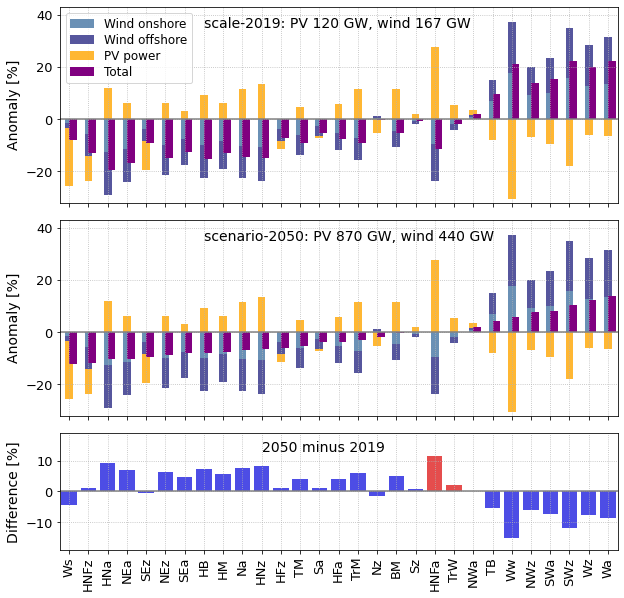

In [41]:
# bar plot of daily anomalies of PV and wind power stacked, in order of increasing total
import matplotlib.gridspec as gridspec

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharex=True, gridspec_kw={'height_ratios':[1,1,.6]})
fig.subplots_adjust(hspace = 0.1) #, wspace=.15)

## Barplot of anomalies SCALE 2019 =========================

to_barplot2019[['GWL', 'Wp_on', 'Wp_off', 'PV']].set_index('GWL').reindex(order_total_anomalies).plot.bar(stacked=True, 
            color=[color_PV_wind_total[1], color_PV_wind_total[2], color_PV_wind_total[0]], label=['Wind power', 'PV power'], ax=axes[0], width=.4, alpha=.8, align='center')
to_barplot2019[['GWL', 'total']].set_index('GWL').reindex(order_total_anomalies).plot.bar(
            color=color_PV_wind_total[3], label=['Total'], ax=axes[0], stacked=False, align='edge', width=.4, alpha=1)
axes[0].grid(which='major', color='#B4B4B4', linestyle=':')
axes[0].set_ylabel('Anomaly [%]', fontsize=14)
axes[0].set_xlabel('')
plt.xticks(fontsize=14)
axes[0].tick_params(labelsize=13)
axes[0].legend(['Wind onshore', 'Wind offshore', 'PV power', 'Total'], loc='upper left', fontsize=12, labelspacing=.25)
axes[0].axhline(y=0, linestyle='-', color='grey', alpha=2)
axes[0].text(7, 35, 'scale-2019: PV 120 GW, wind 167 GW', fontsize=14)


## Barplot of anomalies 2050 =========================

to_barplot2050.sort_values('total')[['GWL', 'Wp_on', 'Wp_off', 'PV']].set_index('GWL').plot.bar(stacked=True, 
            color=[color_PV_wind_total[1], color_PV_wind_total[2], color_PV_wind_total[0]], label=['Wind power', 'PV power'], ax=axes[1], width=.4, alpha=.8, align='center')
to_barplot2050.sort_values('total')[['GWL', 'total']].set_index('GWL').plot.bar(
            color=color_PV_wind_total[3], label=['Total'], ax=axes[1], stacked=False, align='edge', width=.4, alpha=1)
axes[1].grid(which='major', color='#B4B4B4', linestyle=':')
axes[1].set_ylabel('Anomaly [%]', fontsize=14)
axes[1].set_xlabel('')
plt.xticks(fontsize=14)
axes[1].legend([],[], frameon=False)
axes[1].tick_params(labelsize=13)
axes[1].axhline(y=0, linestyle='-', color='grey', alpha=2)
axes[1].text(7, 35, 'scenario-2050: PV 870 GW, wind 440 GW', fontsize=14)

axes[0].set_ylim([-32,43])
axes[1].set_ylim([-32,43])

## Barplot of changes in anomalies from 2019 - 2050 =============================

df_change_sign = (to_barplot2050.set_index('GWL')['total'] - to_barplot2019.set_index('GWL')['total']).reset_index(drop=False)
df_change_sign['changed_sign'] = False
test_sign = to_barplot2050.set_index('GWL')['total'] * to_barplot2019.set_index('GWL')['total']
for GWL in list_lgcGWL:
    df_change_sign.loc[df_change_sign['GWL']==GWL, 'changed_sign'] = test_sign[GWL] < 0

changed_sign_palette = ['blue', 'red']
# df_change_sign.set_index('GWL').plot.bar(hue='changed_sign', palette=changed_sign_palette, ax=axes[2], width=.4, alpha=.8, align='center', order=order_total_anomalies)
sns.barplot(data=df_change_sign, x='GWL', y='total', ax=axes[2], hue='changed_sign', palette=changed_sign_palette, order=order_total_anomalies, alpha=.8, dodge=False)
axes[2].grid(which='major', color='#B4B4B4', linestyle=':')
axes[2].axhline(y=0, linestyle='-', color='grey', alpha=2)
axes[2].set_ylabel('Difference [%]', fontsize=14)
axes[2].set_xlabel('')
plt.xticks(rotation=90, fontsize=14)
axes[2].tick_params(labelsize=13)
plt.legend([],[], frameon=False)
axes[2].text(10, 13, r"2050 minus 2019", fontsize=14)
axes[2].set_ylim([-19,19])
# axes[2].set_yticklabels([-10,0,10])

# fig.tight_layout()
# fig.savefig('Paper1/Paper1_v8_Fig1_Barplot_percentage_PV_wind_anomalies_hourly_withdifference_offshore.pdf', dpi=300, transparent=True, bbox_inches = "tight")

In [109]:
print('For scale-2019 total production min {:.2f}% and max {:.2f}%'.format(min(to_barplot2019['total']), max(to_barplot2019['total'])))
print('For scenario-2050 total production min {:.2f}% and max {:.2f}%'.format(min(to_barplot2050['total']), max(to_barplot2050['total'])))
print('For newratio5 total production min {:.2f}% and max {:.2f}%'.format(min(to_barplot['total']), max(to_barplot['total'])))

For scale-2019 total production min -19.46% and max 22.35%
For scenario-2050 total production min -12.10% and max 13.88%
For newratio5 total production min -16.50% and max 11.99%


### Try to add wind onshore offshore

In [ ]:
d=xr.open_dataset("/home/linhho/Documents/Code_PhD/CONST/COSMO_REA6_CONST_withOUTsponge.nc")
mask_land = d['FR_LAND'].data[::8, ::8] >= .5
mask_sea  = d['FR_LAND'].data[::8, ::8] < .5
# mask_sea = np.logical_not(mask_land)

### Germany

In [79]:
## Barplot for === GERMANY === compare to Druecke 2020

fromcsv = pd.read_csv('/net/respos/linhho/energy_model/mask/Timeseries_Germany_hourly_scen2050_1995_2017_GW.csv', sep='\t')
df_de = fromcsv.copy()
df_de['total'] = df_de['PV'] + df_de['Wp']
df_de['GWL'] = df_hourly_all['lgcGWL'].tolist()
mean_total = np.nanmean(df_de['total'])
mean_PV = np.nanmean(df_de['PV'])
mean_Wp = np.nanmean(df_de['Wp'])
print(mean_total, mean_PV, mean_Wp)

## Anomalies (percentage) compared to mean hourly production of GWL of season
to_barplot = df_de.groupby(['GWL']).mean()
to_barplot['total'] = (to_barplot['total'] - mean_total)/mean_total*100
to_barplot['PV'] = (to_barplot['PV'] - mean_PV)/mean_PV*100
to_barplot['Wp'] = (to_barplot['Wp'] - mean_Wp)/mean_Wp*100

to_barplot.reset_index(drop=False, inplace=True)

## 2019
fromcsv = pd.read_csv('/net/respos/linhho/energy_model/mask/Timeseries_Germany_hourly_scale2019_1995_2017_GW.csv', sep='\t')
df_de = fromcsv.copy()
df_de['total'] = df_de['PV'] + df_de['Wp']
df_de['GWL'] = df_hourly_all['lgcGWL'].tolist()
mean_total = np.nanmean(df_de['total'])
mean_PV = np.nanmean(df_de['PV'])
mean_Wp = np.nanmean(df_de['Wp'])
print(mean_total, mean_PV, mean_Wp)

## Anomalies (percentage) compared to mean hourly production of GWL of season
to_barplot2019 = df_de.groupby(['GWL']).mean()
to_barplot2019['total'] = (to_barplot2019['total'] - mean_total)/mean_total*100
to_barplot2019['PV'] = (to_barplot2019['PV'] - mean_PV)/mean_PV*100
to_barplot2019['Wp'] = (to_barplot2019['Wp'] - mean_Wp)/mean_Wp*100

to_barplot2019.reset_index(drop=False, inplace=True)

21.37906686288586 11.311039873590254 10.06802698929561
5.381417306947718 1.5601434308400346 3.8212738761076848


In [80]:
color_PV_wind_total = ['orange', '#4575A3', 'purple']

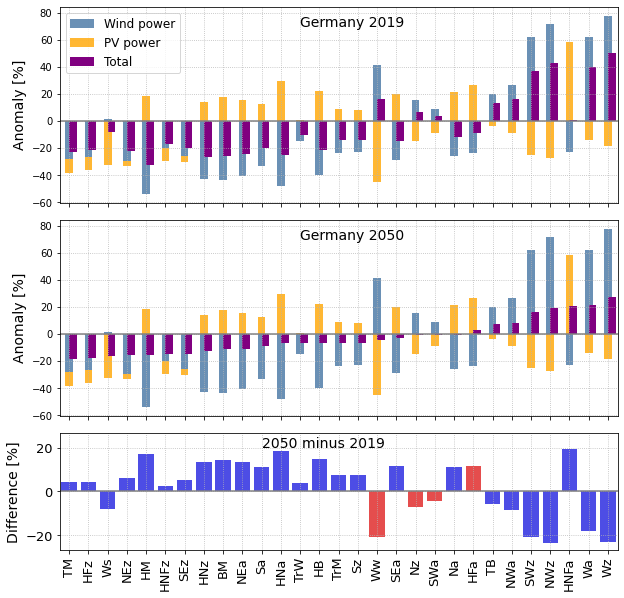

In [82]:
### Germany

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharex=True, gridspec_kw={'height_ratios':[1,1,.6]})
fig.subplots_adjust(hspace = 0.1) #, wspace=.15)

order_total_anomalies = to_barplot.sort_values('total')['GWL']
to_barplot2019['GWL'] = pd.Categorical(to_barplot2019['GWL'], categories=order_total_anomalies)
                                                                                                          
## Germany 2050
to_barplot2019[['GWL', 'Wp', 'PV']].set_index('GWL').reindex(order_total_anomalies).plot.bar(stacked=True, 
            color=[color_PV_wind_total[1], color_PV_wind_total[0]], label=['Wind power', 'PV power'], ax=axes[0], width=.4, alpha=.8, align='center')
to_barplot2019[['GWL', 'total']].set_index('GWL').reindex(order_total_anomalies).plot.bar(
            color=color_PV_wind_total[2], label=['Total'], ax=axes[0], stacked=False, align='edge', width=.4, alpha=1)
axes[0].grid(which='major', color='#B4B4B4', linestyle=':')
axes[0].set_ylabel('Anomaly [%]', fontsize=14)
axes[0].set_xlabel('')
axes[0].legend(['Wind power', 'PV power', 'Total'], loc='upper left', fontsize=12)
axes[0].axhline(y=0, linestyle='-', color='grey', alpha=2)
axes[0].text(12, 70, 'Germany 2019', fontsize=14)

## Germany scale 2019
to_barplot.sort_values('total')[['GWL', 'Wp', 'PV']].set_index('GWL').plot.bar(stacked=True, 
            color=[color_PV_wind_total[1], color_PV_wind_total[0]], label=['Wind power', 'PV power'], ax=axes[1], width=.4, alpha=.8, align='center')
to_barplot.sort_values('total')[['GWL', 'total']].set_index('GWL').plot.bar(
            color=color_PV_wind_total[2], label=['Total'], ax=axes[1], stacked=False, align='edge', width=.4, alpha=1)
axes[1].grid(which='major', color='#B4B4B4', linestyle=':')
axes[1].set_ylabel('Anomaly [%]', fontsize=14)
axes[1].set_xlabel('')
axes[1].legend([],[], frameon=False)
axes[1].axhline(y=0, linestyle='-', color='grey', alpha=2)
axes[1].text(12, 70, 'Germany 2050', fontsize=14)

## Barplot of changes in anomalies from 2019 - 2050 =============================
df_change_sign = (to_barplot.set_index('GWL')['total'] - to_barplot2019.set_index('GWL')['total']).reset_index(drop=False)
df_change_sign['changed_sign'] = False
test_sign = to_barplot.set_index('GWL')['total'] * to_barplot2019.set_index('GWL')['total']
for GWL in list_lgcGWL:
    df_change_sign.loc[df_change_sign['GWL']==GWL, 'changed_sign'] = test_sign[GWL] < 0

changed_sign_palette = ['blue', 'red']
sns.barplot(data=df_change_sign, x='GWL', y='total', ax=axes[2], hue='changed_sign', palette=changed_sign_palette, order=order_total_anomalies, alpha=.8, dodge=False)
axes[2].grid(which='major', color='#B4B4B4', linestyle=':')
axes[2].axhline(y=0, linestyle='-', color='grey', alpha=2)
axes[2].set_ylabel('Difference [%]', fontsize=14)
axes[2].set_xlabel('')
plt.xticks(rotation=90, fontsize=14)
axes[2].tick_params(labelsize=13)
plt.legend([],[], frameon=False)
axes[2].text(10, 20, r"2050 minus 2019", fontsize=14)
axes[2].set_ylim([-27,27])

# fig.savefig('Paper1/Paper1_v8_Supplementary_Barplot_percentage_PV_wind_anomalies_hourly_Germany.pdf'.format(name_PERIOD), dpi=300, transparent=True, bbox_inches = "tight")

# Seasonality

In [61]:
stat_anomalies_from_csv = pd.read_csv('Paper1_stats_anomalies_percentage_hourly_byGWL_season_{}_{}.csv'.format(name_PERIOD, name_scen), sep='\t')
stat_anomalies_from_csv[stat_anomalies_from_csv['Season']=='winter'].sort_values('total')

,GWL,PV,Wp,total,Season,count_total,count_day
36,HNa,-14.919981,-26.168129,-22.481751,winter,4192.0,94.0
45,SEz,-22.603170,-17.290816,-19.031845,winter,4192.0,71.0
39,NEz,-1.648254,-22.071262,-15.377989,winter,4192.0,56.0
35,HNFz,-3.618163,-17.980351,-13.273402,winter,4192.0,103.0
30,HB,14.595669,-25.987954,-12.687402,winter,4192.0,135.0
33,HM,10.366817,-23.358431,-12.305588,winter,4192.0,197.0
44,SEa,7.212631,-20.721102,-11.566324,winter,4192.0,139.0
51,TM,6.738459,-20.247398,-11.403269,winter,4192.0,35.0
37,HNz,9.721390,-21.587213,-11.326382,winter,4192.0,68.0
42,Na,23.707677,-27.426839,-10.668422,winter,4192.0,85.0


In [63]:
plot_season

,GWL,PV,Wp,total,Season,count_total,count_day,Group
0,BM,11.660215,-10.560206,-0.305852,annual,8401.0,778.0,group3_lowwindhighPV
1,HB,9.366263,-22.724909,-7.915368,annual,8401.0,266.0,group3_lowwindhighPV
2,HFa,5.693870,-11.873234,-3.766309,annual,8401.0,214.0,group2_average
3,HFz,-3.389638,-8.236902,-5.999971,annual,8401.0,255.0,group2_average
4,HM,6.021056,-19.120805,-7.518255,annual,8401.0,351.0,group3_lowwindhighPV
...,...,...,...,...,...,...,...,...
82,TrW,1.635775,4.794922,2.943679,summer,4209.0,224.0,group2_average
83,Wa,4.327682,22.492042,11.847825,summer,4209.0,108.0,group1_highwindlowPV
84,Ws,-10.458722,-14.252380,-12.029317,summer,4209.0,62.0,group4_darkdoldrum
85,Ww,-17.868282,43.130348,7.385480,summer,4209.0,27.0,group1_highwindlowPV


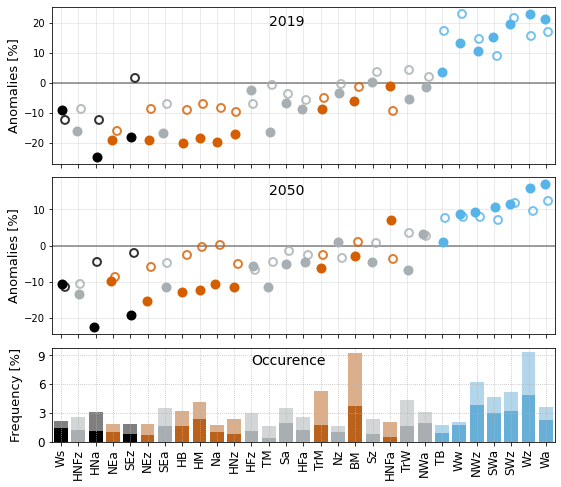

In [78]:
### SEASONALITY

## PLOT
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9,8), sharex=True, gridspec_kw={'height_ratios':[1,1,.6]})
fig.subplots_adjust(hspace = 0.1) #, wspace=.15)
                                                                                             
### Total 2019 ===

stat_anomalies_from_csv2019 = pd.read_csv('Paper1_stats_anomalies_percentage_hourly_byGWL_season_1995_2017_scale2019.csv', sep='\t')
# order_total_anomalies = stat_anomalies_from_csv2019[stat_anomalies_from_csv2019['Season']=='annual'].sort_values('total')['GWL']
stat_anomalies_from_csv2050 = pd.read_csv('Paper1_stats_anomalies_percentage_hourly_byGWL_season_{}_scen2050.csv'.format(name_PERIOD), sep='\t')
order_total_anomalies = stat_anomalies_from_csv2050[stat_anomalies_from_csv2050['Season']=='annual'].sort_values('total')['GWL']

plot_season = stat_anomalies_from_csv2019.copy()[stat_anomalies_from_csv2019['Season'].isin(['winter', 'summer'])]
plot_season['Group'] = None
for group in list(GWL_groups.keys()):
    for GWL in GWL_groups[group]:
        plot_season.loc[plot_season['GWL']==GWL, 'Group'] = group
plot_season['Group'] = pd.Categorical(plot_season['Group'], categories=list(GWL_groups.keys()))

sns.stripplot(data=plot_season[plot_season['Season']=='winter'], x="GWL", y="total", hue="Group", s=10, palette=colour_list_GWL_groups, 
              order= order_total_anomalies, ax=axes[0])
sns.stripplot(data=plot_season[plot_season['Season']=='summer'], x="GWL", y="total", hue="Group", s=15, marker="$\circ$", 
              palette=colour_list_GWL_groups, order=order_total_anomalies, alpha=.8, ax=axes[0])

axes[0].grid(True, alpha=.3)
axes[0].axhline(y=0, linestyle='-', color='grey')
axes[0].set_ylabel('Anomalies [%]', fontsize=13)
axes[0].set_xlabel(None)
# plt.xticks(rotation=90, fontsize=12)
axes[0].legend([],[], frameon=False)
axes[0].text(12, 19, '2019', fontsize=14)

### 2050 ===

plot_season = stat_anomalies_from_csv2050.copy() # [stat_anomalies_from_csv['Season'].isin(['winter', 'summer'])]
plot_season['Group'] = None
for group in list(GWL_groups.keys()):
    for GWL in GWL_groups[group]:
        plot_season.loc[plot_season['GWL']==GWL, 'Group'] = group
plot_season['Group'] = pd.Categorical(plot_season['Group'], categories=list(GWL_groups.keys()))

sns.stripplot(data=plot_season[plot_season['Season']=='winter'], x="GWL", y="total", hue="Group", s=10, palette=colour_list_GWL_groups, 
              order= order_total_anomalies, ax=axes[1])
sns.stripplot(data=plot_season[plot_season['Season']=='summer'], x="GWL", y="total", hue="Group", s=15, marker="$\circ$", 
              palette=colour_list_GWL_groups, order=order_total_anomalies, alpha=.8, ax=axes[1])

axes[1].grid(True, alpha=.3)
axes[1].axhline(y=0, linestyle='-', color='grey')
axes[1].set_ylabel('Anomalies [%]', fontsize=13)
axes[1].set_xlabel(None)
axes[1].legend([],[], frameon=False)
axes[1].text(12, 14, '2050', fontsize=14)

### Frequency =============================================

barplot_season = plot_season.copy()
barplot_season['frequency'] = barplot_season['count_day'] / 8401.0 *100

sns.barplot(x="GWL",y="frequency",data=barplot_season[barplot_season['Season']=='winter'].sort_values('total'), hue='Group', 
            palette=colour_list_GWL_groups, dodge=False, order=order_total_anomalies, alpha=1)
sns.barplot(x="GWL",y="frequency",data=barplot_season[barplot_season['Season']=='annual'].sort_values('total'), hue='Group', 
            palette=colour_list_GWL_groups, dodge=False, order=order_total_anomalies, alpha=.5)

axes[2].grid(which='major', color='#B4B4B4', linestyle=':')
# axes[2].set_xticks([])   # no x-tick label
plt.xticks(rotation=90, fontsize=12)
axes[2].set_xlabel('', fontsize=12)
axes[2].set_yticks([0,3,6,9])
axes[2].tick_params(labelsize=12)
axes[2].set_ylabel('Frequency [%]', fontsize=13, labelpad=15)
axes[2].legend([],[], frameon=False)
axes[2].text(11, 8, 'Occurence', fontsize=14)

# fig.savefig('Paper1/Paper1_v8_Fig3_Seasonality_anomalies_total_1995_2017_with2019.pdf'.format(name_PERIOD), dpi=300, transparent=True, bbox_inches = "tight")

# Fig 4: Scatter plot
- Normalised anomalies for PV and wind power generation (no unit)
- Alpha: frequency, size: mean total production for that GWL, colour: groupping

In [84]:
## Select only SEASON
# df_daily = df_daily_all[df_daily_all["Season"]==season_sel].copy()
df_daily = df_daily_all.copy()

# Calculate frequency of GWL
counts = df_daily.groupby(['lgcGWL'])
df_daily_frequency = counts.size()/len(df_daily)*100  # actually a pd Series
# df_daily_frequency

lgcGWL
BM      9.260802
HB      3.166290
HFa     2.559219
HFz     3.035353
HM      4.178074
HNFa    2.083085
HNFz    2.594929
HNa     3.094870
HNz     2.344959
NEa     1.809308
NEz     1.809308
NWa     3.059160
NWz     6.249256
Na      1.737888
Nz      1.702178
SEa     3.547197
SEz     1.833115
SWa     4.666111
SWz     5.154148
Sa      3.559100
Sz      2.380669
TB      1.785502
TM      1.618855
TrM     5.296988
TrW     4.332818
Wa      3.606713
Ws      2.190215
Ww      2.023569
Wz      9.320319
dtype: float64

In [85]:
# Mean PV and wind and total production for each GWL
stats_overall = pd.DataFrame({'GWL': list_lgcGWL,
                              'frequency': np.nan,
                           'PV': np.nan,
                           'Wp': np.nan,
                           'total': np.nan,
                           },
                         columns = ['GWL', 'Frequency [%]', 'PV', 'Wp', 'Total [GW]'])
stats_overall =  stats_overall.set_index('GWL')

# Same as ts_all.groupby(['GWL']).mean()
for GWL in list_lgcGWL:
    stats_overall.at[GWL,'Frequency [%]'] = df_daily_frequency.loc[GWL]
    stats_overall.at[GWL,'PV'] = np.mean(ts_all['PV'].loc[ts_all['GWL']==GWL])
    stats_overall.at[GWL,'Wp'] = np.mean(ts_all['Wp'].loc[ts_all['GWL']==GWL])
    stats_overall.at[GWL,'Total [GW]'] = np.mean(ts_all['total'].loc[ts_all['GWL']==GWL])
stats_overall

,Frequency [%],PV,Wp,Total [GW]
GWL,,,,
Nz,1.70218,122.747,152.952,275.699
BM,9.2608,144.768,135.316,280.084
NWz,6.24926,120.82,181.665,302.485
SWa,4.66611,117.139,186.624,303.764
SWz,5.15415,106.425,203.858,310.283
Wz,9.32032,121.618,193.89,315.508
NWa,3.05916,132,153.918,285.918
HNa,3.09487,144.939,107.176,252.115
TrM,5.29699,144.726,127.515,272.241


In [86]:
print(stats_overall['Total [GW]'].min(), stats_overall['Total [GW]'].max())
# 246.95644475138286 319.58792946841487

246.95644475138286 319.9438236370814


In [87]:
# normalise anomalies to (-1,1) by (value - average)/(largest possible differences (min or max - avg))
PV_avg_range = [stats_overall['PV'].mean(),
    max(stats_overall['PV'].mean() - stats_overall['PV'].min(), stats_overall['PV'].max() - stats_overall['PV'].mean())]
Wp_avg_range = [stats_overall['Wp'].mean(),
    max(stats_overall['Wp'].mean() - stats_overall['Wp'].min(), stats_overall['Wp'].max() - stats_overall['Wp'].mean())]
total_avg_range = [stats_overall['Total [GW]'].mean(),
    max(stats_overall['Total [GW]'].mean() - stats_overall['Total [GW]'].min(), stats_overall['Total [GW]'].max() - stats_overall['Total [GW]'].mean())]
print(PV_avg_range, Wp_avg_range, total_avg_range)
# [129.59606254106947, 39.53303998077304] [145.5158778030608, 61.89207220005167] [275.11194034413035, 44.475989124284524]

[129.64428726902023, 39.58126470872379] [145.5441103373192, 61.86383966579325] [275.1883976063395, 44.75542603074189]


In [88]:
# Normalised anomalies, compare to average over the whole period
stats_overall_anomalies = pd.DataFrame({'GWL': list_lgcGWL,
                           'PV': np.nan,
                           'Wp': np.nan,
                           'total': np.nan,
                           'group': None,
                           },
                         columns = ['GWL','PV', 'Wp', 'total', 'group'])
stats_overall_anomalies =  stats_overall_anomalies.set_index('GWL')

for GWL in list_lgcGWL:
    stats_overall_anomalies.at[GWL,'PV'] = (stats_overall.at[GWL,'PV'] - PV_avg_range[0])/PV_avg_range[1]*100
    stats_overall_anomalies.at[GWL,'Wp'] = (stats_overall.at[GWL,'Wp'] - Wp_avg_range[0])/Wp_avg_range[1]*100
    stats_overall_anomalies.at[GWL,'total'] = (stats_overall.at[GWL,'Total [GW]'] - total_avg_range[0])/total_avg_range[1]*100
stats_overall_anomalies

,PV,Wp,total,group
GWL,,,,
Nz,-17.4254,11.9741,1.14058,NaN
BM,38.2101,-16.5333,10.9393,NaN
NWz,-22.2941,58.3872,60.9899,NaN
SWa,-31.5928,66.4041,63.8477,NaN
SWz,-58.6628,94.2619,78.414,NaN
Wz,-20.2785,78.1496,90.0894,NaN
NWa,5.95106,13.5356,23.9728,NaN
HNa,38.642,-62.0206,-51.5542,NaN
TrM,38.1037,-29.1433,-6.58516,NaN


In [89]:
# max and min to add range to scatter plots
stats_overall_ranges = pd.DataFrame({'GWL': list_lgcGWL,
                           'PV_min': np.nan,
                           'PV_max': np.nan,
                           'Wp_min': np.nan,
                           'Wp_max': np.nan,
                           },
                         columns = ['GWL','PV_min', 'PV_max', 'Wp_min', 'Wp_max'])
stats_overall_ranges =  stats_overall_ranges.set_index('GWL')

for GWL in list_lgcGWL:
    stats_overall_ranges.at[GWL,'PV_min'] = np.min(stats_overall.at[GWL,'PV'])
    stats_overall_ranges.at[GWL,'PV_max'] = np.max(stats_overall.at[GWL,'PV'])
    stats_overall_ranges.at[GWL,'Wp_min'] = np.min(stats_overall.at[GWL,'Wp'])
    stats_overall_ranges.at[GWL,'Wp_max'] = np.max(stats_overall.at[GWL,'Wp'])
stats_overall_ranges

,PV_min,PV_max,Wp_min,Wp_max
GWL,,,,
Nz,122.747,122.747,152.952,152.952
BM,144.768,144.768,135.316,135.316
NWz,120.82,120.82,181.665,181.665
SWa,117.139,117.139,186.624,186.624
SWz,106.425,106.425,203.858,203.858
Wz,121.618,121.618,193.89,193.89
NWa,132,132,153.918,153.918
HNa,144.939,144.939,107.176,107.176
TrM,144.726,144.726,127.515,127.515


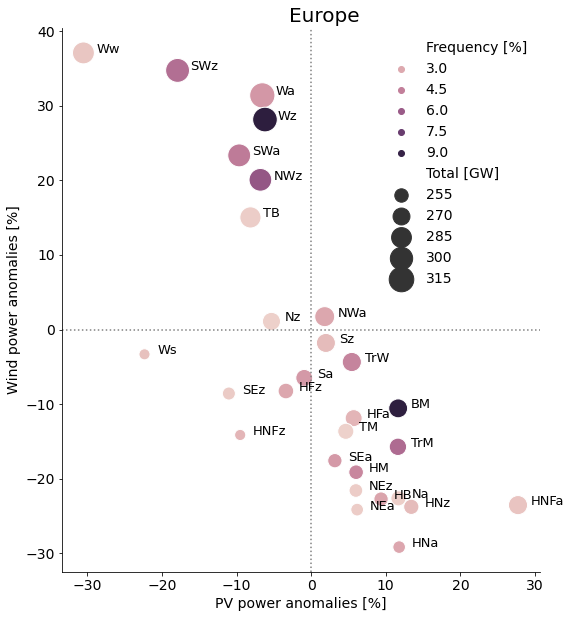

In [98]:
## Scatter plot WITHOUT normalised - version 4 (2022-05-05)
## Just (value - mean)/mean*100, limit axis is NOT 100 anymore
## Solve the inconsistency of Ws wind negative anomaly now

fig, ax = plt.subplots(figsize=(10,10))
minsize = min(stats_overall['Total [GW]'])/2
maxsize = max(stats_overall['Total [GW]'])*2
scatter = sns.scatterplot(data=to_barplot2050.set_index('GWL'), x='PV', y='Wp', hue=stats_overall['Frequency [%]'],  # palette=plt.get_cmap('magma_r'), 
                size=stats_overall['Total [GW]'], sizes=(minsize, maxsize)) #, style='Type')
#                 markers={'High PV & high wind':'s', 'High PV & low wind':'o', 'Low PV & high wind':'^', 'Low PV & low wind':'x'})
for i, point in to_barplot2050.set_index('GWL').iterrows():
    ax.annotate(i, (point['PV'], point['Wp']), textcoords='offset points', xytext=(13,0),
                family='sans-serif', fontsize=13, color='black')
ax.set_ylabel("Wind power anomalies [%]", fontsize=14)
ax.set_xlabel("PV power anomalies [%]", fontsize=14)
ax.set_title("Europe", position=(0.55, 0.95), fontsize=20)
ax.tick_params(labelsize=14)

ax.set_aspect('equal', adjustable='box')  # keep the same scale on x- and y-axis
ax.axhline(y=0, color='grey', linestyle=':')
ax.axvline(x=0, color='grey', linestyle=':')
legend = ax.legend(loc='upper right', fontsize=14)
legend.get_frame().set_linewidth(0.0)
# plt.legend(*scatter.legend_elements("sizes", num=4))

right_side = ax.spines["right"]
right_side.set_visible(False)
upper_side = ax.spines["top"]
upper_side.set_visible(False)

figname = 'Atlas_scatterplot_anomalies_GWL_' + name_PERIOD + '.pdf'
# fig.savefig('Paper1_{}_v4_Fig4_scatterplot_anomalies_GWL_hourly_percentage_NO_normalised.pdf'.format(name_PERIOD), dpi=300)


In [92]:
stats_overall2019 = to_barplot2019.copy().set_index('GWL')
for GWL in list_lgcGWL:
    stats_overall2019.at[GWL, 'Frequency [%]'] = stats_overall.at[GWL, 'Frequency [%]']
stats_overall2019

,PV,Wp,total,Season,count_total,count_day,Group,Frequency [%]
GWL,,,,,,,,
BM,11.598074,-10.560206,-5.309903,annual,8401.0,778.0,High PV,9.260802
HB,9.299545,-22.724909,-15.129825,annual,8401.0,266.0,High PV,3.166290
HFa,5.938792,-11.873234,-7.643095,annual,8401.0,214.0,High PV,2.559219
HFz,-3.448575,-8.236902,-7.113888,annual,8401.0,255.0,Moderate,3.035353
HM,5.956378,-19.120805,-13.176573,annual,8401.0,351.0,High PV,4.178074
HNFa,27.646219,-23.532671,-11.387429,annual,8401.0,175.0,High PV,2.083085
HNFz,-9.573444,-14.129773,-13.060943,annual,8401.0,218.0,Dark doldrum,2.594929
HNa,11.723864,-29.160011,-19.459409,annual,8401.0,260.0,High PV,3.094870
HNz,13.375449,-23.762756,-14.952962,annual,8401.0,196.0,High PV,2.344959


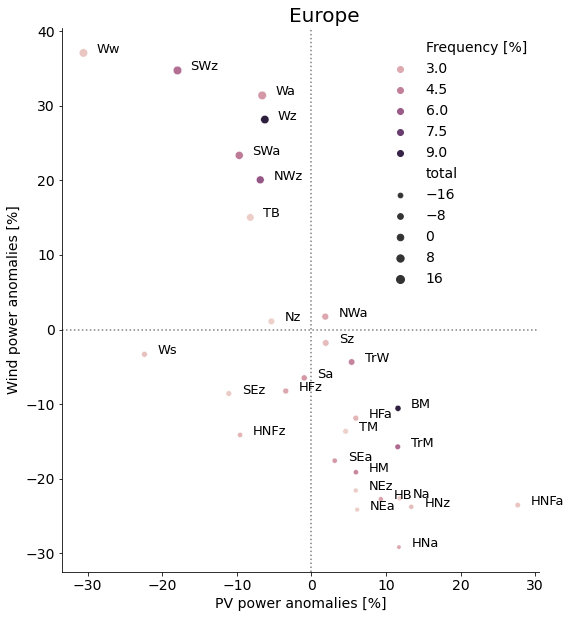

In [93]:
fig, ax = plt.subplots(figsize=(10,10))
# minsize = min(stats_overall2019['total'])/2
# maxsize = max(stats_overall2019['total'])*2
scatter = sns.scatterplot(data=stats_overall2019, x='PV', y='Wp', hue=stats_overall2019['Frequency [%]'],  # palette=plt.get_cmap('magma_r'), 
                size=stats_overall2019['total']) #, sizes=(minsize, maxsize)) #, style='Type')
#                 markers={'High PV & high wind':'s', 'High PV & low wind':'o', 'Low PV & high wind':'^', 'Low PV & low wind':'x'})
for i, point in stats_overall2019.iterrows():
    ax.annotate(i, (point['PV'], point['Wp']), textcoords='offset points', xytext=(13,0),
                family='sans-serif', fontsize=13, color='black')
ax.set_ylabel("Wind power anomalies [%]", fontsize=14)
ax.set_xlabel("PV power anomalies [%]", fontsize=14)
ax.set_title("Europe", position=(0.55, 0.95), fontsize=20)
ax.tick_params(labelsize=14)

ax.set_aspect('equal', adjustable='box')  # keep the same scale on x- and y-axis
ax.axhline(y=0, color='grey', linestyle=':')
ax.axvline(x=0, color='grey', linestyle=':')
legend = ax.legend(loc='upper right', fontsize=14)
legend.get_frame().set_linewidth(0.0)
# plt.legend(*scatter.legend_elements("sizes", num=4))

right_side = ax.spines["right"]
right_side.set_visible(False)
upper_side = ax.spines["top"]
upper_side.set_visible(False)

figname = 'Atlas_scatterplot_anomalies_GWL_scale2019' + name_PERIOD + '.pdf'
# fig.savefig('Paper1_{}_Fig4_scatterplot_anomalies_GWL_hourly_percentage_v3.pdf'.format(name_PERIOD), dpi=300)


In [251]:
# read energy data
fname = Dir['out_dir'] + '????_PV_wind_generation_v2.nc'
ds = xr.open_mfdataset(fname, parallel=True)
ds

<xarray.Dataset>
Dimensions:    (lat: 106, lon: 103, time: 201624)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 ... 2017-12-31T23:00:00
Dimensions without coordinates: lat, lon
Data variables:
    PV2050_CF  (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
    Wp2050     (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
    Wp_CF      (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
    Wp2050_CF  (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
    Wp         (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
    PV2050     (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
Attributes:
    Conventions:  
    Title:        Energy model output version 2 (2021-09-07)
    Author:       Linh Ho, Institute of Geophysics and Meteorology, Universit...
    History:      2021-11-18 16:51:07.479371 Python2
    References:   
    Notes:        Wind speed at hubheight interpolated from wind at level 36 ...

In [259]:
## Scatter plots for 4 regions

region = 'C'

if region=='Europe':  ## whole Europe
    reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 0,103,0,106
elif region=='A':  ## Scandinavia
    reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 82,102,57,77  # Scandinavia  ## new, ver2, to capture the tip of Scandinavia which is anti-correlated with Western Europe (2022-05-30)
elif region=='B':  # ## Germany and North Sea
    reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 50,70,40,60
elif region=='C':  # ## Iberia
    reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 25,45,15,35
elif region=='D':  # ## Southeastern Europe
    reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 20,40,60,80

PV_domain = ds['PV2050'][:,reg_lon1:reg_lon2, reg_lat1:reg_lat2]
Wp_domain = ds['Wp2050'][:,reg_lon1:reg_lon2, reg_lat1:reg_lat2]

ts_all_reg = pd.DataFrame({'time': pd.date_range(dt.datetime(period[0],1,1,0,0,0), dt.datetime(period[1]+1,1,1,0,0,0), freq='H', closed="left"),
                           'PV': np.nansum(PV_domain, axis=(1,2)),
                           'Wp': np.nansum(Wp_domain, axis=(1,2)),
                           'GWL': np.repeat(df_daily['lgcGWL'], 24).tolist()
                           },
                         columns = ['time','PV', 'Wp', 'GWL'])
ts_all_reg['total'] = ts_all_reg['PV'] + ts_all_reg['Wp']
ts_all_reg

,time,PV,Wp,GWL,total
0,1995-01-01 00:00:00,0.0,27941.600956,Nz,27941.600956
1,1995-01-01 01:00:00,0.0,26747.777948,Nz,26747.777948
2,1995-01-01 02:00:00,0.0,25598.597420,Nz,25598.597420
3,1995-01-01 03:00:00,0.0,25136.228166,Nz,25136.228166
4,1995-01-01 04:00:00,0.0,24197.010543,Nz,24197.010543
...,...,...,...,...,...
201619,2017-12-31 19:00:00,0.0,23371.176920,Wz,23371.176920
201620,2017-12-31 20:00:00,0.0,23457.380476,Wz,23457.380476
201621,2017-12-31 21:00:00,0.0,24344.196669,Wz,24344.196669
201622,2017-12-31 22:00:00,0.0,23618.363248,Wz,23618.363248


In [260]:
# Mean PV and wind and total production for each GWL
stats_overall_reg = pd.DataFrame({'GWL': list_lgcGWL,
                              'frequency': np.nan,
                           'PV': np.nan,
                           'Wp': np.nan,
                           'total': np.nan,
                           },
                         columns = ['GWL', 'Frequency [%]', 'PV', 'Wp', 'Total [GW]'])
stats_overall_reg =  stats_overall_reg.set_index('GWL')

for GWL in list_lgcGWL:
    stats_overall_reg.at[GWL,'Frequency [%]'] = df_daily_frequency.loc[GWL]
    stats_overall_reg.at[GWL,'PV'] = np.mean(ts_all_reg['PV'].loc[ts_all_reg['GWL']==GWL])
    stats_overall_reg.at[GWL,'Wp'] = np.mean(ts_all_reg['Wp'].loc[ts_all_reg['GWL']==GWL])
    stats_overall_reg.at[GWL,'Total [GW]'] = np.mean(ts_all_reg['total'].loc[ts_all_reg['GWL']==GWL])
    
# normalise anomalies to (-1,1) by (value - average)/(largest possible differences (min or max - avg))
## mean of mean of 29 GWL values
PV_avg_range_reg = [stats_overall_reg['PV'].mean(),
    max(stats_overall_reg['PV'].mean() - stats_overall_reg['PV'].min(), stats_overall_reg['PV'].max() - stats_overall_reg['PV'].mean())]
Wp_avg_range_reg = [stats_overall_reg['Wp'].mean(),
    max(stats_overall_reg['Wp'].mean() - stats_overall_reg['Wp'].min(), stats_overall_reg['Wp'].max() - stats_overall_reg['Wp'].mean())]
total_avg_range_reg = [stats_overall_reg['Total [GW]'].mean(),
    max(stats_overall_reg['Total [GW]'].mean() - stats_overall_reg['Total [GW]'].min(), stats_overall_reg['Total [GW]'].max() - stats_overall_reg['Total [GW]'].mean())]
print(PV_avg_range_reg, Wp_avg_range_reg, total_avg_range_reg)

# Normalised anomalies, compare to average over the whole period
stats_overall_anomalies_reg = pd.DataFrame({'GWL': list_lgcGWL,
                           'PV': np.nan,
                           'Wp': np.nan,
                           'total': np.nan,
                           'group': None,
                           },
                         columns = ['GWL','PV', 'Wp', 'total', 'group'])
stats_overall_anomalies_reg =  stats_overall_anomalies_reg.set_index('GWL')

for GWL in list_lgcGWL:
    ## Simple normalised, used in the paper, mean of the whole time series
    stats_overall_anomalies_reg.at[GWL,'PV'] = (stats_overall_reg.at[GWL,'PV'] - ts_all_reg['PV'].mean())/ts_all_reg['PV'].mean()*100
    stats_overall_anomalies_reg.at[GWL,'Wp'] = (stats_overall_reg.at[GWL,'Wp'] - ts_all_reg['Wp'].mean())/ts_all_reg['Wp'].mean()*100
    stats_overall_anomalies_reg.at[GWL,'total'] = (stats_overall_reg.at[GWL,'Total [GW]'] - ts_all_reg['total'].mean())/ts_all_reg['total'].mean()*100

[31035.719716847787, 6218.27847551935] [8751.35755370482, 6749.206054178701] [39787.077270552596, 6897.973854050913]


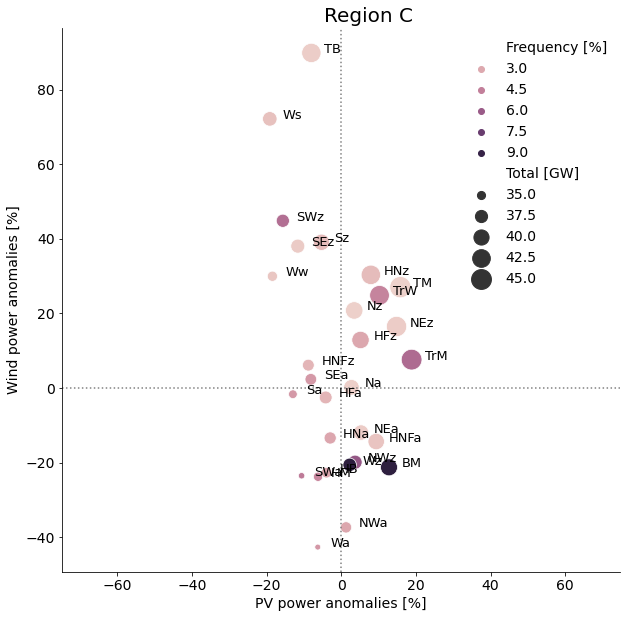

In [261]:
## Scatter plot WITHOUT normalised - version 4 (2022-05-05)
## Just (value - mean)/mean*100, limit axis is NOT 100 anymore
## Solve the inconsistency of Ws wind negative anomaly now

fig, ax = plt.subplots(figsize=(10,10))
    
## Eyeball from min max values in 4 regions
minsize = 7*5 # min(stats_overall['Total [GW]'])/2
maxsize = 90*5 # max(stats_overall['Total [GW]'])*2
scatter = sns.scatterplot(data=stats_overall_anomalies_reg, x='PV', y='Wp', hue=stats_overall_reg['Frequency [%]'],  # palette=plt.get_cmap('magma_r'), 
                size=stats_overall_reg['Total [GW]']/1000, sizes=(minsize, maxsize)) #, style='Type')
#                 markers={'High PV & high wind':'s', 'High PV & low wind':'o', 'Low PV & high wind':'^', 'Low PV & low wind':'x'})
for i, point in stats_overall_anomalies_reg.iterrows():
    ax.annotate(i, (point['PV'], point['Wp']), textcoords='offset points', xytext=(13,0),
                family='sans-serif', fontsize=13, color='black')
ax.set_ylabel("Wind power anomalies [%]", fontsize=14)
ax.set_xlabel("PV power anomalies [%]", fontsize=14)
ax.set_title("Region " + region, position=(0.55, 0.95), fontsize=20)
ax.tick_params(labelsize=14)

# ax.set_aspect('equal', adjustable='box')  # keep the same scale on x- and y-axis
ax.axis("equal")
ax.axhline(y=0, color='grey', linestyle=':')
ax.axvline(x=0, color='grey', linestyle=':')
legend = ax.legend(loc='upper right', fontsize=14)
legend.get_frame().set_linewidth(0.0)
# plt.legend(*scatter.legend_elements("sizes", num=4))

right_side = ax.spines["right"]
right_side.set_visible(False)
upper_side = ax.spines["top"]
upper_side.set_visible(False)

fig.savefig('Paper1/Paper1_SUP_{}_scatterplot_anomalies_GWL_hourly_percentage_region{}.pdf'.format(name_PERIOD, region), dpi=300)
